<img src="https://drive.google.com/uc?id=1DvKhAzLtk-Hilu7Le73WAOz2EBR5d41G" width="500"/>

---


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install livelossplot
!pip install torchinfo
# !cp -r /content/drive/MyDrive/Dataset/real_hands.tar.gz '/content/real_hands.tar.gz'
# !tar -xzvf real_hands.tar.gz

### ***Name***: [*Wenbo*]
### ***username***: [*Yu*]
### ***CID***: [*02452289*]


You can save this notebook in Colab by clicking `File` from the top menu, and then selecting `Download --> Download .ipynb`

Make sure that when you save your notebook you have all the cells executed and you can see the outputs (livelossplot graphs, etc)

## Hyperparameter tunning notebook

Explain the steps and tests you do.

Organise it well to show how the data you present here has helped you design your final network hyperparameters (that you will use for the final training in the `yourusername_DLcw1_clean.ipynb` notebook).

add text blocks as you need

## 1. Data preparation

### 1.1 Define helper functions

In [3]:
import os
import shutil
from pathlib import Path
from PIL import Image
import random
from matplotlib import pyplot as plt
plt.style.use('default')
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Directory where the images are stored
source_dir = Path("real_hands")

# Directories for train and test datasets
train_img_dir = Path("data/train_dir/hand")
test_img_dir = Path("data/test_dir/hand")

# Create the directories if they don't exist
train_img_dir.mkdir(parents=True, exist_ok=True)
test_img_dir.mkdir(parents=True, exist_ok=True)

def train_test_split(source_dir, train_img_dir, test_img_dir, total_images, split=1.0):
    train_images = int(total_images * split)
    # delete the files in the train_img_dir and test_img_dir
    for filename in os.listdir(train_img_dir):
        file_path = train_img_dir / filename
        if file_path.exists():
            os.remove(file_path)
    for filename in os.listdir(test_img_dir):
        file_path = test_img_dir / filename
        if file_path.exists():
            os.remove(file_path)

    for i in range(total_images):
        source_file = source_dir / f"{i:06d}.jpeg"
        if i < train_images:
            # Copy to train directory
            shutil.copy(source_file, train_img_dir)
        else:
            # Copy to test directory
            shutil.copy(source_file, test_img_dir)

    # Check the number of files in each directory to confirm
    num_train_files = len(list(train_img_dir.glob("*.jpeg")))
    num_test_files = len(list(test_img_dir.glob("*.jpeg")))

    num_train_files, num_test_files


def get_random_image(image_path, seed=42):
    # Set seed
    random.seed(seed) # <- try changing this and see what happens

    image_path = Path(image_path)
    # 1. Get all image paths (* means "any combination")
    image_path_list = list(image_path.glob("*/*/*.jpeg"))

    # 2. Get random image path
    random_image_path = random.choice(image_path_list)

    # 3. Get image class from path name (the image class is the name of the directory where the image is stored)
    image_class = random_image_path.parent.stem

    # 4. Open image
    img = Image.open(random_image_path)

    # 5. Print metadata
    print(f"Random image path: {random_image_path}")
    print(f"Image class: {image_class}")
    print(f"Image height: {img.height}")
    print(f"Image width: {img.width}")
    return img

# visualize original images
def visualize_raw_images(image_path, cols=10, rows=10, seed=42):
    random.seed(seed) # <- try changing this and see what happens
    image_path = Path(image_path)
    image_path_list = list(image_path.glob("*/*/*.jpeg"))
    figure = plt.figure(figsize=(8, 8))

    for i in range(cols * rows):
        random_image_path = random.choice(image_path_list)
        img = Image.open(random_image_path)
        figure.add_subplot(rows, cols, i+1)
        plt.axis("off")
        plt.imshow(img, cmap="gray")

    return image_path_list

def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=10)

def data_transform(shape=32, flip_prob=0.5):
    # Write transform for image
    data_transform = transforms.Compose([
        # Resize the images to 32x32
        transforms.Resize(size=(shape, shape)),
        # Flip the images randomly on the horizontal
        transforms.RandomHorizontalFlip(p=flip_prob), # p = probability of flip, 0.5 = 50% chance
        # Turn the image into a torch.Tensor
        transforms.Grayscale(),
        transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
    ])
    return data_transform

### 1.2 Prepare dataset and dataloader

In [6]:
from torchvision import datasets
from torch.utils.data import DataLoader
train_test_split(source_dir, train_img_dir, test_img_dir, 8000)
train_dir = Path("data/train_dir")
BATCH_SIZE = 32

train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform(), # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

print(f"Number of training examples: {len(train_data)}")
print(f"Number of batches: {len(train_dataloader)}")

Number of training examples: 8000
Number of batches: 250


## 2. Final model - DCGAN

### 2.1 DCGAN model

This model is based on the structure of DCGAN and is adapted to 32*32 grayscale images.

In [7]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from livelossplot import PlotLosses
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
import random
from torch import tensor
from tqdm.auto import tqdm
from PIL import Image
from torch import optim
import torchvision
# from torchinfo import summary
# import seaborn as sns

class Generator(nn.Module):

    def __init__(self, channels_noise=100, num_units=32):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # hidden layers
            self._hidden_block(channels_noise, num_units*4, 4, 1, 0),
            self._hidden_block(num_units*4, num_units*2, 4, 2, 1),
            self._hidden_block(num_units*2, num_units, 4, 2, 1),
            # output Layer
            nn.ConvTranspose2d(in_channels=num_units,
                               out_channels=1,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.Tanh()
        )

    def _hidden_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,
                               out_channels,
                               kernel_size,
                               stride,
                               padding,
                               bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    # All modules must override `forward`
    def forward(self, x):
        x = self.main(x)
        return x

class Discriminator(nn.Module):

    def __init__(self, channels_img=1, num_units=32):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            # input is 1ch x 32w x 32h
            nn.Conv2d(in_channels=channels_img,
                      out_channels=num_units,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.LeakyReLU(negative_slope=0.2),
            # hidden layers
            self._hidden_block(num_units, num_units*2, 4, 2, 1),
            self._hidden_block(num_units*2, num_units*4, 4, 2, 1),
            # Output layer
            nn.Conv2d(in_channels=num_units*4,
                      out_channels=1,
                      kernel_size=4,
                      stride=1,
                      padding=0,
                      bias=False),
            nn.Sigmoid()
        )
    def _hidden_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels,
                      out_channels,
                      kernel_size,
                      stride,
                      padding,
                      bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.2),
        )

    def forward(self, x):
        x = self.main(x)
        return x

### 2.2 Training and evaluation functions

In [13]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

def GAN_train(G: torch.nn.Module,
              D: torch.nn.Module,
              G_optimizer: torch.optim.Optimizer,
              D_optimizer: torch.optim.Optimizer,
              loss_fn: torch.nn.Module,
              test_noise: torch.Tensor,
              data_loader: torch.utils.data.DataLoader,
              device='cpu',
              n_epochs=5,
              checkpoint=None,
              target_dir='./models/GAN/',
              model_name='dcgan',
              save_inv=5,
              D_losses=None,
              G_losses=None,):
    target_dir = Path(target_dir) / model_name
    if D_losses is None:
      D_losses = []
    if G_losses is None:
      G_losses = []
    start_epoch = 0
    groups = {'Loss': ['D_Loss', 'G_Loss']}
    liveloss = PlotLosses(groups=groups)
    liveloss.update({})

    # load checkpoint if specified
    if checkpoint is not None:
        G, D, G_optimizer, D_optimizer, start_epoch, _, _ = GAN_load_model(G, D, G_optimizer, D_optimizer, checkpoint)
        # liveloss loads the previous epoch
        for epoch in range(start_epoch + 1):
          liveloss.update({})
    # training loop
    for epoch in tqdm(range(start_epoch, start_epoch + n_epochs), initial=start_epoch, total=start_epoch + n_epochs):
        current_epoch = epoch + 1
        logs = {}

        # print(f"Epoch: {current_epoch}/{start_epoch + n_epochs}")
        print("Example images:")
        generated_images = G(test_noise).detach().to('cpu')
        show_images(generated_images)

        D_loss , G_loss = 0.0, 0.0
        # batch loop
        for idx, (batch, _) in enumerate(data_loader):
            # print(f"\rEpoch: {epoch}\tBatch: {i}/{len(train_dataloader)}", end='')
            ## Train the discriminiator ##
            D.train()
            D_optimizer.zero_grad()

            # Compute error on real data
            real = Variable(batch).to(device)
            real_labels = Variable(torch.ones(real.size(0), 1, 1, 1)).to(device)
            real_predictions = D(real)
            d_error_real = loss_fn(real_predictions, real_labels)

            # Compute error on fake data
            noise = Variable(torch.randn(real.size(0), 100, 1, 1)).to(device)
            fake = G(noise)
            fake_predictions = D(fake.detach())
            fake_labels = Variable(torch.zeros(real.size(0), 1, 1, 1)).to(device)
            d_error_fake = loss_fn(fake_predictions, fake_labels)

            # Accumulate and backpropogate on combined error
            d_error_total = d_error_real + d_error_fake
            d_error_total.backward()
            D_optimizer.step()

            ## Train the generator ##
            G.train()
            G_optimizer.zero_grad()

            # Compute rate of fakes being detected
            goal_labels = Variable(torch.ones(real.size(0), 1, 1, 1)).to(device)
            results = D(fake)
            g_error = loss_fn(results, goal_labels)

            # Backpropogate and update weights
            g_error.backward()
            G_optimizer.step()

            D_loss += d_error_total.data.item()
            G_loss += g_error.data.item()

        D_loss /= len(data_loader)
        G_loss /= len(data_loader)
        D_losses.append(D_loss)
        G_losses.append(G_loss)
        logs['D_Loss'] = D_loss
        logs['G_Loss'] = G_loss

        # change liveloss figure size
        plt.rcParams['figure.figsize'] = [5, 5]
        liveloss.update(logs)
        liveloss.draw()

        # save model every save_inv epochs
        if current_epoch % save_inv == 0:
            print(target_dir)
            GAN_save_model(G, D, G_optimizer, D_optimizer, target_dir, model_name, epoch=current_epoch, D_loss=D_loss, G_loss=G_loss)

    return D_losses, G_losses, start_epoch, n_epochs

def GAN_save_model(G: torch.nn.Module,
                   D: torch.nn.Module,
                   G_optimizer : torch.optim.Optimizer,
                   D_optimizer : torch.optim.Optimizer,
                   target_dir: str,
                   model_name: str,
                   epoch=None,
                   G_loss=None,
                   D_loss=None,
                   info=False):
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True, exist_ok=True)

  # Create model path
  if epoch is not None:
    model_name = f"{model_name}_{epoch}.pth"
  else:
    model_name = f"{model_name}.pth"

  model_save_path = target_dir_path / model_name
  # Save the model state_dict()
  if info:
    print(f"[INFO] Saving model to: {model_save_path}")

  checkpoint = {
    'G_state_dict': G.state_dict(),
    'D_state_dict': D.state_dict(),
    'G_optimizer_state_dict': G_optimizer.state_dict(),
    'D_optimizer_state_dict': D_optimizer.state_dict(),
    'epoch': epoch,
  }
  if G_loss is not None:
    checkpoint['G_loss'] = G_loss
  if D_loss is not None:
    checkpoint['D_loss'] = D_loss
  torch.save(obj=checkpoint, f=model_save_path)

# load GAN model from checkpoint function
def GAN_load_model(G: torch.nn.Module,
                   D: torch.nn.Module,
                   G_optimizer : torch.optim.Optimizer,
                   D_optimizer : torch.optim.Optimizer,
                   checkpoint_path: str,
                   info=False):
  # Load checkpoint
  checkpoint = torch.load(checkpoint_path)
  # Load model weights
  G.load_state_dict(checkpoint['G_state_dict'])
  D.load_state_dict(checkpoint['D_state_dict'])
  # Load optimizer state
  G_optimizer.load_state_dict(checkpoint['G_optimizer_state_dict'])
  D_optimizer.load_state_dict(checkpoint['D_optimizer_state_dict'])
  # Load epoch
  epoch = checkpoint['epoch']
  # Load loss
  G_loss, D_loss = None, None
  if 'G_loss' in checkpoint:
    G_loss = checkpoint['G_loss']
  if 'D_loss' in checkpoint:
    D_loss = checkpoint['D_loss']
  if info:
    print(f"[INFO] Loading checkpoint from: {checkpoint_path}")
    print(f"[INFO] Loaded checkpoint at epoch: {epoch}")

  return G, D, G_optimizer, D_optimizer, epoch, G_loss, D_loss

def show_images(images):
    img = torchvision.utils.make_grid(images, normalize=True)
    npy_img = img.numpy()
    plt.imshow(np.transpose(npy_img, (1, 2, 0)),
               interpolation='nearest')
    plt.show()

def GAN_results(G: torch.nn.Module,
                D: torch.nn.Module,
                loss_fn: torch.nn.Module,
                train_dataloader,
                test_num=1000,
                device='cpu',
                seed=42):
    set_seed(seed)
    D_loss, G_loss = 0.0, 0.0
    with torch.inference_mode():
      for idx, (batch, _) in enumerate(train_dataloader):
          D.eval()
          # Compute error on real data
          real = Variable(batch).to(device)
          real_labels = Variable(torch.ones(real.size(0), 1, 1, 1)).to(device)
          real_predictions = D(real)
          d_error_real = loss_fn(real_predictions, real_labels)

          # Compute error on fake data
          noise = Variable(torch.randn(real.size(0), 100, 1, 1)).to(device)
          fake = G(noise)
          fake_predictions = D(fake.detach())
          fake_labels = Variable(torch.zeros(real.size(0), 1, 1, 1)).to(device)
          d_error_fake = loss_fn(fake_predictions, fake_labels)

          # Accumulate and backpropogate on combined error
          d_error_total = d_error_real + d_error_fake
          ## Train the generator ##
          G.eval()

          # Compute rate of fakes being detected
          goal_labels = Variable(torch.ones(real.size(0), 1, 1, 1)).to(device)
          results = D(fake)
          g_error = loss_fn(results, goal_labels)

          D_loss += d_error_total.data.item()
          G_loss += g_error.data.item()
          if idx > test_num:
            break
      D_loss /= test_num
      G_loss /= test_num
    return D_loss, G_loss

### 2.1 Hyperparameters

The important adjustable parameters are as follows.

**Data preprocessing:**

- transforms.RandomHorizontalFlip(p=flip_prob): probability of flip
- batch_size: 

**Model Structure:**

- num_units: control the number of hidden layer neurons
- channels_noise: the size of the channel noise
- LeakyReLU(negative_slope=): after testing, it was found that 0.2 is optimal

**Training process:**

- lr: learn rate
- betas(Adam optimizer): adam optimizer parameters
- loss_fn: loss function

### 2.2 Hyperparameters tunning process

#### 2.2.1 Model_v0

First, adjust the number of num_units to half of the original DCGAN to adapt to the 32\*32 input, because the original DCGAN model is designed based on 64\*64 images.

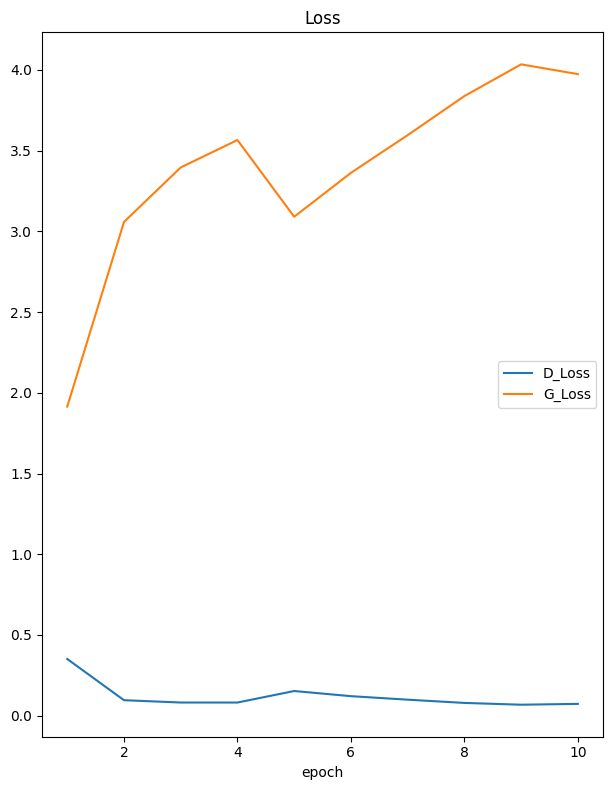

Loss
	D_Loss           	 (min:    0.068, max:    0.351, cur:    0.073)
	G_Loss           	 (min:    1.915, max:    4.034, cur:    3.974)
models/GAN/dcgan_v0


In [15]:
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on device!")
    device = 'cuda'
else:
    print("No device available!")
# Hyperparameters
NUM_UNITS = 64
CHANNELS_NOISE = 100
LR = 0.00001
BATAS = (0.5, 0.999)
loss_fn = nn.BCELoss()

# Create the networks
G0 = Generator(num_units=NUM_UNITS).to(device)
D0 = Discriminator(num_units=NUM_UNITS).to(device)
# Create an optimizer to update the weights of each network
g_optimizer0 = optim.Adam(G0.parameters(), lr=LR, betas=BATAS)
d_optimizer0 = optim.Adam(D0.parameters(), lr=LR, betas=BATAS)
# Create a noise vector to feed into the generator
test_noise = torch.randn((8, 100, 1, 1)).to(device)

D_losses_0, G_losses_0 = [], []
D_losses_0, G_losses_0, start_epoch_0, n_epochs_0 = GAN_train(G=G0,
                                                        D=D0,
                                                        G_optimizer=g_optimizer0,
                                                        D_optimizer=d_optimizer0,
                                                        loss_fn=loss_fn,
                                                        test_noise=test_noise,
                                                        data_loader=train_dataloader,
                                                        device=device,
                                                        n_epochs=10,
                                                        save_inv=2,
                                                        model_name='dcgan_v0',
                                                        D_losses=D_losses_0,
                                                        G_losses=G_losses_0)

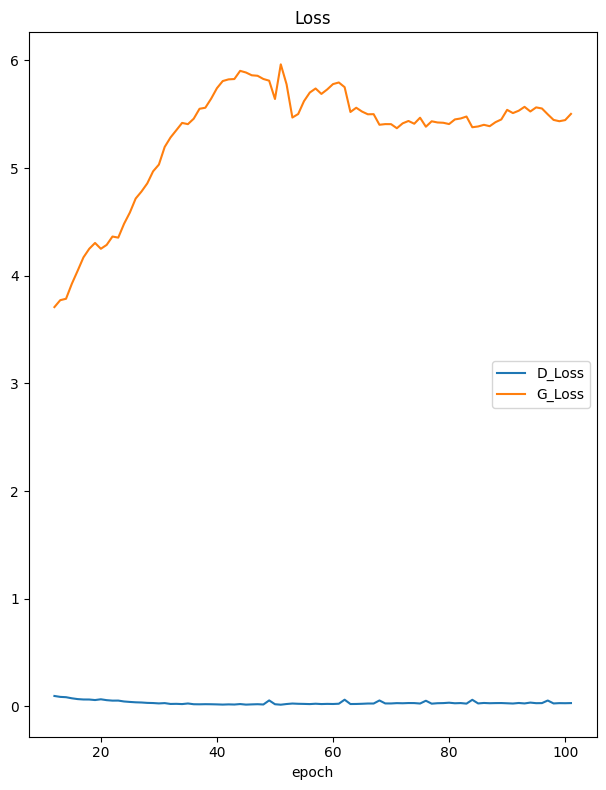

Loss
	D_Loss           	 (min:    0.016, max:    0.098, cur:    0.031)
	G_Loss           	 (min:    3.709, max:    5.964, cur:    5.504)
models/GAN/dcgan_v0


In [16]:
# retrain
D_losses_0, G_losses_0 = [], []
D_losses_0, G_losses_0, start_epoch_0, n_epochs_0 = GAN_train(G=G0,
                                                        D=D0,
                                                        G_optimizer=g_optimizer0,
                                                        D_optimizer=d_optimizer0,
                                                        loss_fn=loss_fn,
                                                        test_noise=test_noise,
                                                        data_loader=train_dataloader,
                                                        device=device,
                                                        n_epochs=90,
                                                        save_inv=10,
                                                        model_name='dcgan_v0',
                                                        checkpoint='/content/models/GAN/dcgan_v0/dcgan_v0_10.pth',
                                                        D_losses=D_losses_0,
                                                        G_losses=G_losses_0)

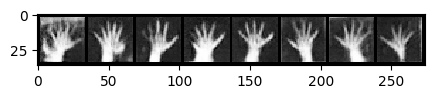

In [17]:
generated_images = G0(test_noise).detach().to('cpu')
show_images(generated_images)

It may be that the above model parameters are too complex and therefore converge slowly.

### 2.2.2 Model_v0_1

In Model_v0_1, adjust the learning rate slightly to increase the convergence speed.

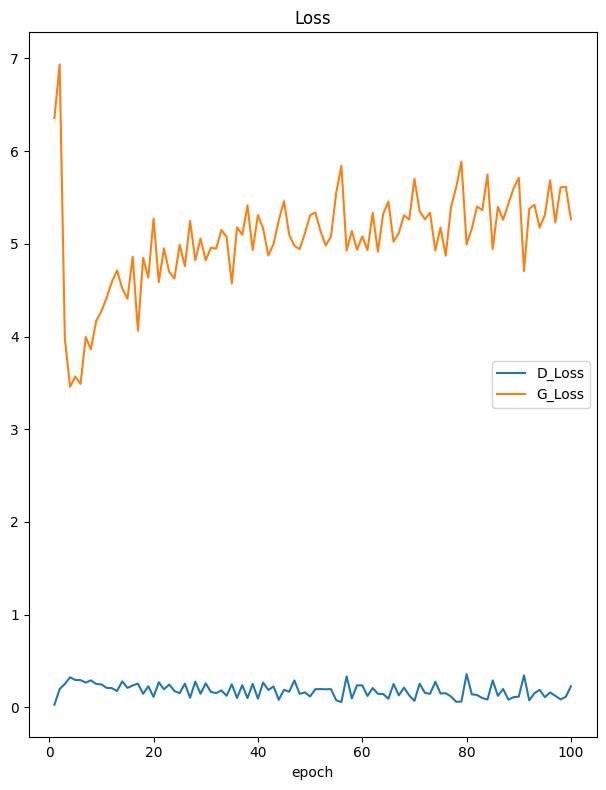

Loss
	D_Loss           	 (min:    0.029, max:    0.358, cur:    0.228)
	G_Loss           	 (min:    3.457, max:    6.936, cur:    5.264)
models/GAN/dcgan_v0_1


In [19]:
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on device!")
    device = 'cuda'
else:
    print("No device available!")
# Hyperparameters
NUM_UNITS = 64
CHANNELS_NOISE = 100
LR = 0.0002
BATAS = (0.5, 0.999)
loss_fn = nn.BCELoss()

# Create the networks
G0_1 = Generator(num_units=NUM_UNITS).to(device)
D0_1 = Discriminator(num_units=NUM_UNITS).to(device)
# Create an optimizer to update the weights of each network
g_optimizer0_1 = optim.Adam(G0_1.parameters(), lr=LR, betas=BATAS)
d_optimizer0_1 = optim.Adam(D0_1.parameters(), lr=LR, betas=BATAS)
# Create a noise vector to feed into the generator
test_noise = torch.randn((8, 100, 1, 1)).to(device)

D_losses_0_1, G_losses_0_1 = [], []
D_losses_0_1, G_losses_0_1, start_epoch_0_1, n_epochs_0_1 = GAN_train(G=G0_1,
                                                        D=D0_1,
                                                        G_optimizer=g_optimizer0_1,
                                                        D_optimizer=d_optimizer0_1,
                                                        loss_fn=loss_fn,
                                                        test_noise=test_noise,
                                                        data_loader=train_dataloader,
                                                        device=device,
                                                        n_epochs=100,
                                                        save_inv=5,
                                                        model_name='dcgan_v0_1',
                                                        D_losses=D_losses_0_1,
                                                        G_losses=G_losses_0_1)

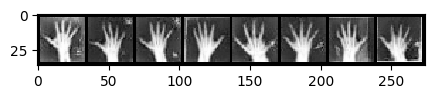

In [20]:
generated_images = G0_1(test_noise).detach().to('cpu')
show_images(generated_images)

It can be found that the model has been significantly improved.

### 2.2.3 Model_v0_2

Adjust channels_noises and train again.

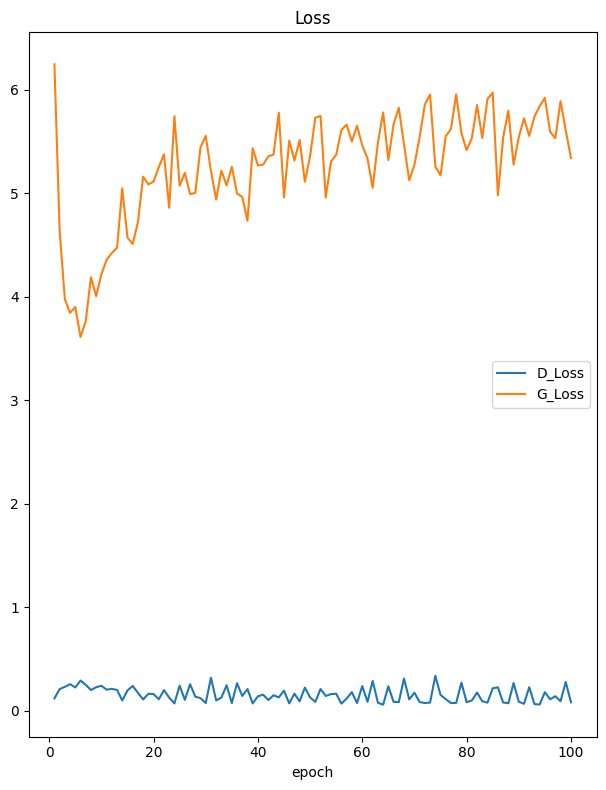

Loss
	D_Loss           	 (min:    0.059, max:    0.338, cur:    0.082)
	G_Loss           	 (min:    3.612, max:    6.245, cur:    5.339)
models/GAN/dcgan_v0_2


In [21]:
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on device!")
    device = 'cuda'
else:
    print("No device available!")
# Hyperparameters
NUM_UNITS = 64
CHANNELS_NOISE = 50
LR = 0.0002
BATAS = (0.5, 0.999)
loss_fn = nn.BCELoss()

# Create the networks
G0_2 = Generator(num_units=NUM_UNITS).to(device)
D0_2 = Discriminator(num_units=NUM_UNITS).to(device)
# Create an optimizer to update the weights of each network
g_optimizer0_2 = optim.Adam(G0_2.parameters(), lr=LR, betas=BATAS)
d_optimizer0_2 = optim.Adam(D0_2.parameters(), lr=LR, betas=BATAS)
# Create a noise vector to feed into the generator
test_noise = torch.randn((8, 100, 1, 1)).to(device)

D_losses_0_2, G_losses_0_2 = [], []
D_losses_0_2, G_losses_0_2, start_epoch_0_2, n_epochs_0_2 = GAN_train(G=G0_2,
                                                        D=D0_2,
                                                        G_optimizer=g_optimizer0_2,
                                                        D_optimizer=d_optimizer0_2,
                                                        loss_fn=loss_fn,
                                                        test_noise=test_noise,
                                                        data_loader=train_dataloader,
                                                        device=device,
                                                        n_epochs=100,
                                                        save_inv=10,
                                                        model_name='dcgan_v0_2',
                                                        D_losses=D_losses_0_2,
                                                        G_losses=G_losses_0_2)

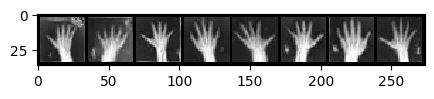

In [22]:
generated_images = G0_2(test_noise).detach().to('cpu')
show_images(generated_images)

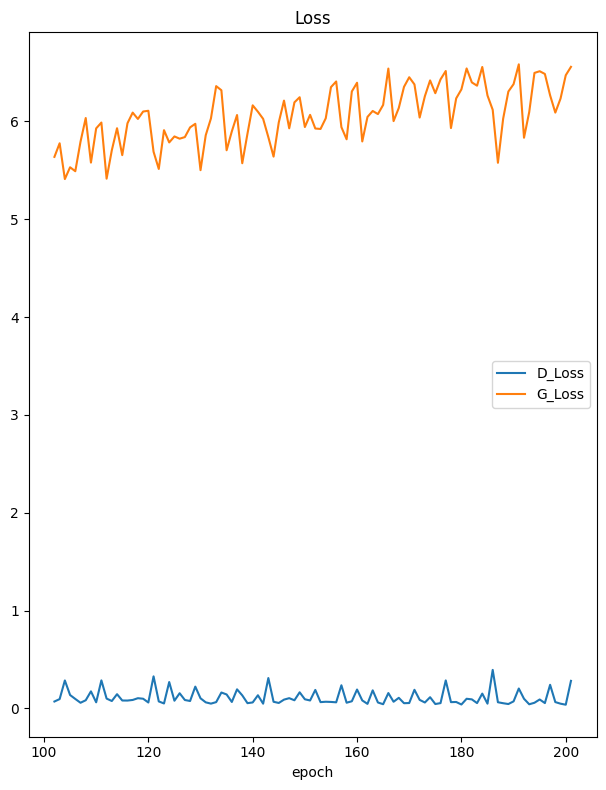

Loss
	D_Loss           	 (min:    0.038, max:    0.393, cur:    0.281)
	G_Loss           	 (min:    5.411, max:    6.583, cur:    6.558)
models/GAN/dcgan_v0_2


In [27]:
# retrain
D_losses_0_2, G_losses_0_2 = [], []
D_losses_0_2, G_losses_0_2, start_epoch_0_2, n_epochs_0_2 = GAN_train(G=G0_2,
                                                        D=D0_2,
                                                        G_optimizer=g_optimizer0_2,
                                                        D_optimizer=d_optimizer0_2,
                                                        loss_fn=loss_fn,
                                                        test_noise=test_noise,
                                                        data_loader=train_dataloader,
                                                        device=device,
                                                        n_epochs=100,
                                                        save_inv=10,
                                                        model_name='dcgan_v0_2',
                                                        checkpoint='/content/models/GAN/dcgan_v0_2/dcgan_v0_2_100.pth',
                                                        D_losses=D_losses_0_2,
                                                        G_losses=G_losses_0_2)

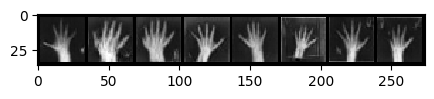

In [30]:
generated_images = G0_2(test_noise).detach().to('cpu')
show_images(generated_images)

Although the training speed has increased, the performance of the model has slightly decreased.

### 2.2.4 Model_v1

Further reduce the number of num_units to observe changes in the model training process.

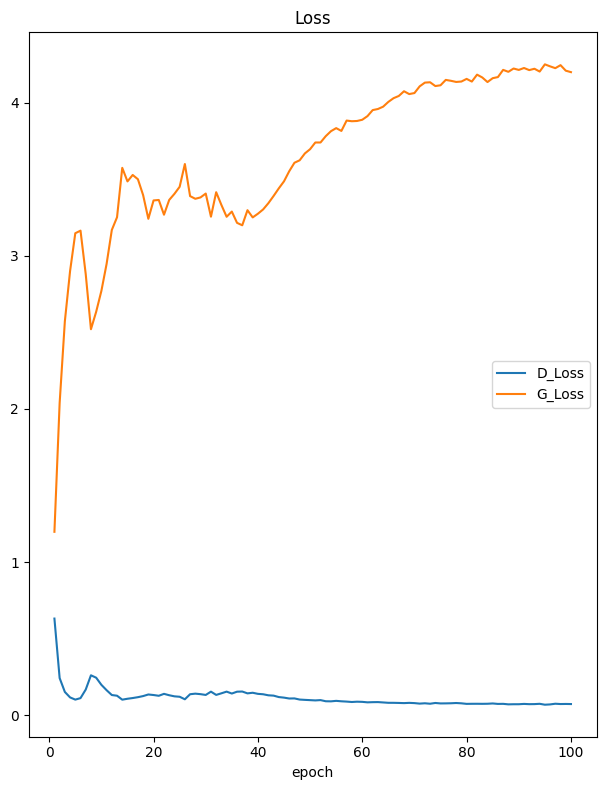

Loss
	D_Loss           	 (min:    0.068, max:    0.631, cur:    0.072)
	G_Loss           	 (min:    1.197, max:    4.251, cur:    4.201)
models/GAN/dcgan_v1


In [23]:
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on device!")
    device = 'cuda'
else:
    print("No device available!")
# Hyperparameters
NUM_UNITS = 32
CHANNELS_NOISE = 100
LR = 0.00001
BATAS = (0.5, 0.999)
loss_fn = nn.BCELoss()

# Create the networks
G1 = Generator(num_units=NUM_UNITS).to(device)
D1 = Discriminator(num_units=NUM_UNITS).to(device)
# Create an optimizer to update the weights of each network
g_optimizer1 = optim.Adam(G1.parameters(), lr=LR, betas=BATAS)
d_optimizer1 = optim.Adam(D1.parameters(), lr=LR, betas=BATAS)
# Create a noise vector to feed into the generator
test_noise = torch.randn((8, 100, 1, 1)).to(device)

D_losses_1, G_losses_1 = [], []
D_losses_1, G_losses_1, start_epoch_1, n_epochs_1 = GAN_train(G=G1,
                                                        D=D1,
                                                        G_optimizer=g_optimizer1,
                                                        D_optimizer=d_optimizer1,
                                                        loss_fn=loss_fn,
                                                        test_noise=test_noise,
                                                        data_loader=train_dataloader,
                                                        device=device,
                                                        n_epochs=100,
                                                        save_inv=10,
                                                        model_name='dcgan_v1',
                                                        D_losses=D_losses_1,
                                                        G_losses=G_losses_1)

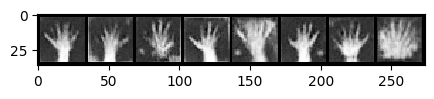

In [24]:
generated_images = G1(test_noise).detach().to('cpu')
show_images(generated_images)

### 2.2.5 Model_v1_1

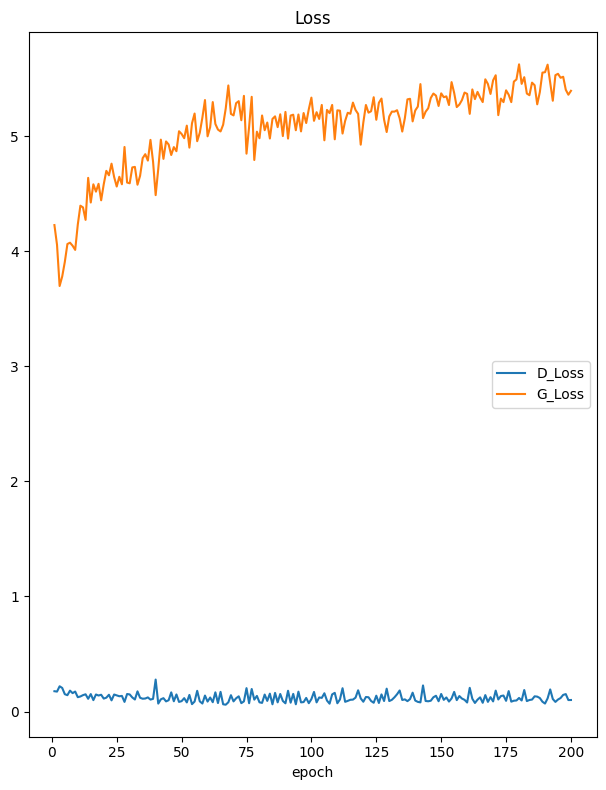

Loss
	D_Loss           	 (min:    0.060, max:    0.278, cur:    0.100)
	G_Loss           	 (min:    3.697, max:    5.623, cur:    5.393)
models/GAN/dcgan_v1_1


In [25]:
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on device!")
    device = 'cuda'
else:
    print("No device available!")
# Hyperparameters
NUM_UNITS = 32
CHANNELS_NOISE = 100
LR = 0.0002
BATAS = (0.5, 0.999)
loss_fn = nn.BCELoss()

# Create the networks
G1_1 = Generator(num_units=NUM_UNITS).to(device)
D1_1 = Discriminator(num_units=NUM_UNITS).to(device)
# Create an optimizer to update the weights of each network
g_optimizer1_1 = optim.Adam(G1_1.parameters(), lr=LR, betas=BATAS)
d_optimizer1_1 = optim.Adam(D1_1.parameters(), lr=LR, betas=BATAS)
# Create a noise vector to feed into the generator
test_noise = torch.randn((8, 100, 1, 1)).to(device)

D_losses_1_1, G_losses_1_1 = [], []
D_losses_1_1, G_losses_1_1, start_epoch_1_1, n_epochs_1_1 = GAN_train(G=G1_1,
                                                        D=D1_1,
                                                        G_optimizer=g_optimizer1_1,
                                                        D_optimizer=d_optimizer1_1,
                                                        loss_fn=loss_fn,
                                                        test_noise=test_noise,
                                                        data_loader=train_dataloader,
                                                        device=device,
                                                        n_epochs=200,
                                                        save_inv=50,
                                                        model_name='dcgan_v1_1',
                                                        D_losses=D_losses_1_1,
                                                        G_losses=G_losses_1_1)

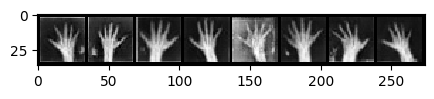

In [31]:
generated_images = G1_1(test_noise).detach().to('cpu')
show_images(generated_images)

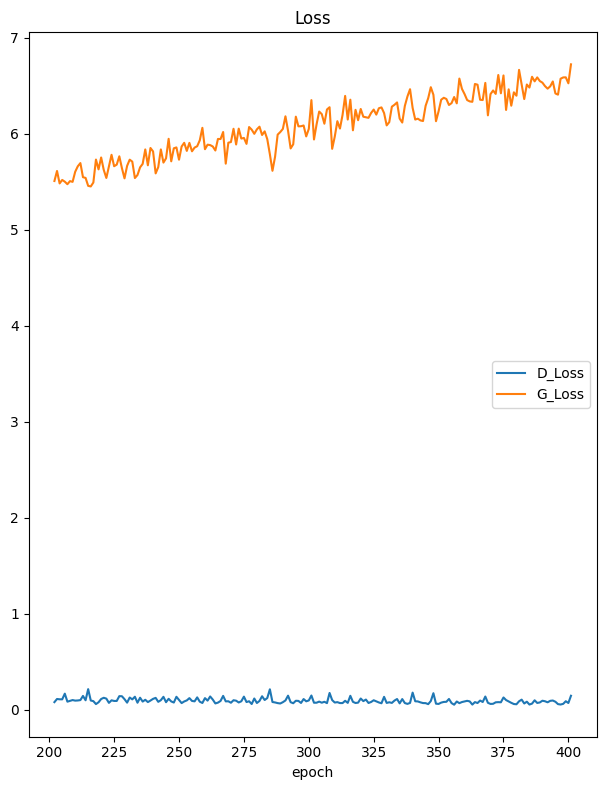

Loss
	D_Loss           	 (min:    0.055, max:    0.217, cur:    0.148)
	G_Loss           	 (min:    5.451, max:    6.723, cur:    6.723)
models/GAN/dcgan_v1_1


In [32]:
# retrain
D_losses_1_1, G_losses_1_1 = [], []
D_losses_1_1, G_losses_1_1, start_epoch_1_1, n_epochs_1_1 = GAN_train(G=G1_1,
                                                        D=D1_1,
                                                        G_optimizer=g_optimizer1_1,
                                                        D_optimizer=d_optimizer1_1,
                                                        loss_fn=loss_fn,
                                                        test_noise=test_noise,
                                                        data_loader=train_dataloader,
                                                        device=device,
                                                        n_epochs=200,
                                                        save_inv=50,
                                                        model_name='dcgan_v1_1',
                                                        checkpoint='/content/models/GAN/dcgan_v1_1/dcgan_v1_1_200.pth',
                                                        D_losses=D_losses_1_1,
                                                        G_losses=G_losses_1_1)

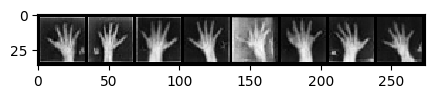

In [35]:
generated_images = G1_1(test_noise).detach().to('cpu')
show_images(generated_images)

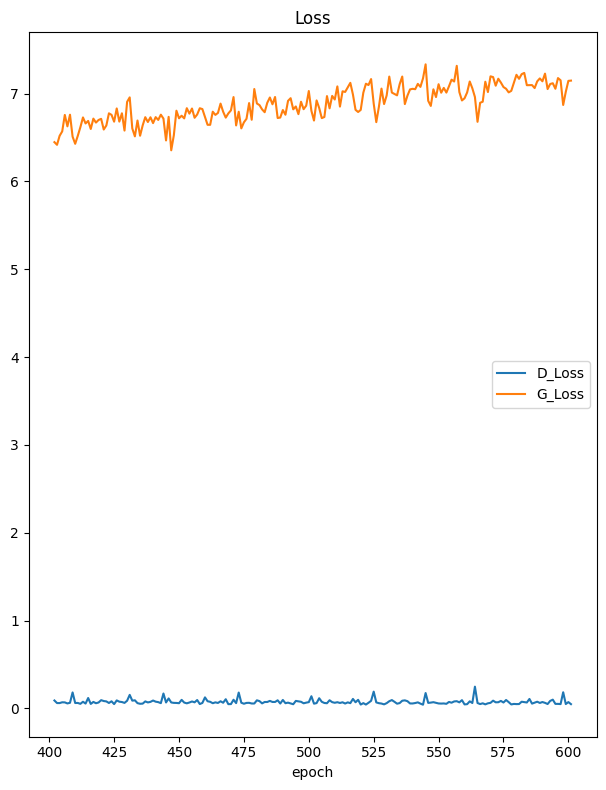

Loss
	D_Loss           	 (min:    0.043, max:    0.248, cur:    0.050)
	G_Loss           	 (min:    6.354, max:    7.333, cur:    7.148)
models/GAN/dcgan_v1_1


In [36]:
# retrain
D_losses_1_1, G_losses_1_1 = [], []
D_losses_1_1, G_losses_1_1, start_epoch_1_1, n_epochs_1_1 = GAN_train(G=G1_1,
                                                        D=D1_1,
                                                        G_optimizer=g_optimizer1_1,
                                                        D_optimizer=d_optimizer1_1,
                                                        loss_fn=loss_fn,
                                                        test_noise=test_noise,
                                                        data_loader=train_dataloader,
                                                        device=device,
                                                        n_epochs=200,
                                                        save_inv=50,
                                                        model_name='dcgan_v1_1',
                                                        checkpoint='/content/models/GAN/dcgan_v1_1/dcgan_v1_1_400.pth',
                                                        D_losses=D_losses_1_1,
                                                        G_losses=G_losses_1_1)

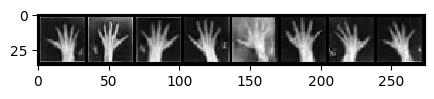

In [38]:
generated_images = G1_1(test_noise).detach().to('cpu')
show_images(generated_images)

When **num_units** is adjusted to 32 and **lr** is adjusted to 0.0002, the model can achieve faster convergence speed while ensuring the quality of the generated images, so this parameter is selected as the parameter of the final model.